In [1]:
import os
import sys
import os
import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision.models as models
from torchvision.models import VGG16_Weights

import torchvision.transforms.functional as F

from torchvision.transforms.functional import to_tensor, resize, center_crop, rotate, adjust_brightness

## Constants

In [2]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

plt.style.use("dark_background")

IMG_SIZE = 512
MASK_SIZE = 128

EPOCHS = 150
PATIENCE = 5
BATCH_SIZE = 8

labels = ['Positive', 'Negative']
selected_colors = ['lightseagreen' , 'violet']
colors = ['mediumvioletred', 'springgreen']


## Utility Functions

In [3]:
def read_data_pathes(path):
    data_map = []
    for sub_dir_path in glob.glob(path+"*"):
        if not os.path.isdir(sub_dir_path):
            print("This is not a dir:", sub_dir_path)
            continue
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
        
    df = pd.DataFrame({'dirname' : data_map[::2], 'path' : data_map[1::2]})
    return df

def separate_and_sort_paths(df, base_len=89, end_img_len=4, end_mask_len=9):
    df_imgs = df[~df['path'].str.contains("mask")]
    df_masks = df[df['path'].str.contains("mask")]

    imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[base_len:-end_img_len]))
    masks = sorted(df_masks["path"].values, key=lambda x: int(x[base_len:-end_mask_len]))

    df = pd.DataFrame({'patient': df_imgs.dirname.values, 'image_path': imgs, 'mask_path': masks})

    return imgs, masks, df

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

def prepare_sample_images(df, row_count, sample_pos_df, sample_neg_df):
    sample_pos_df = sample_pos_df['image_path'].values
    sample_neg_df = sample_neg_df['image_path'].values

    sample_imgs = []
    for neg, pos in zip(sample_neg_df, sample_pos_df):
        neg_img = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
        pos_img = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
        sample_imgs.extend([pos_img, neg_img])

    sample_pos_arr = np.vstack(sample_imgs[::2])
    sample_neg_arr = np.vstack(sample_imgs[1::2])

    return sample_pos_arr, sample_neg_arr


def upsample_dataset(initial_df):
    pos_counts = initial_df['diagnosis'].value_counts() 
    max_count = pos_counts.max()

    dfs = []
    for label, count in pos_counts.items():
        subset_df = initial_df[initial_df['diagnosis'] == label]
        if count < max_count:
            repeat_count = max_count - count
            repeated_subset_df = subset_df.sample(repeat_count, replace=True)
            dfs.append(repeated_subset_df)
    
    initial_df = pd.concat([initial_df] + dfs, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return initial_df

In [4]:
def get_sample_df(df, type, expected, count, column=None):
    sample_df = df[df[type] == expected].sample(count)
    if column: return sample_df[column]
    return sample_df

def get_df_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count).values

def get_img_sample(df, type, expected, count):
    return get_sample_df(df, type, expected, count, column='image_path').values
    
def resize(img, size):
    return cv2.resize(cv2.imread(img), size)

def split(df, test_size):
    df1, df2 = train_test_split(df, stratify=df.diagnosis, test_size=test_size)
    return df1.reset_index(drop=True), df2.reset_index(drop=True) # Is this nessesary or we can del it, for cheating

def print_data_shapes(train_df, val_df, test_df):
    print(f"{'Dataset':<10} {'Shape':<15}")
    print(f"{'-'*25}")
    print(f"{'Train':<10} {train_df.shape}")
    print(f"{'Validation':<10} {val_df.shape}")
    print(f"{'Test':<10} {test_df.shape}")


## Plot Functions

In [5]:
def plot_histogram(df, ylabel='Image Count', title='Dataset Histogram'): 
    ax = df.diagnosis.value_counts().plot(kind='bar', stacked=True, figsize=(10, 6), color=selected_colors)

    for i, rows in enumerate(df.diagnosis.value_counts().values):
        ax.annotate(int(rows), 
                    xy=(i, rows-12), rotation=0, color='white', ha='center', verticalalignment='bottom', fontsize=15, fontweight='bold')

    bounding_box = dict(boxstyle='round', fc=('lightblue'), ec=('black'))
    ax.text(1.2, 2550, f"Total {len(df)} images", size=15, color='black', ha='center', va='center', bbox=bounding_box)
    ax.set_xticklabels(labels, rotation=45, fontsize=12);
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title,fontsize = 18, y=1.05)

def plot_distribution(df, ylabel='Total Images', title='Dataset Distribution'):
    patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
    patients_by_diagnosis.columns = ["Positive", "Negative"]
    
    ax = patients_by_diagnosis.plot(kind='bar',stacked=True, figsize=(18, 10), color=selected_colors, alpha=0.9)
    ax.legend(fontsize=20);
    ax.set_xlabel('Patients',fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_title(title,fontsize = 25, y=1.005)
    ax.set_xticklabels([])

def plot_masks(df):
    sample_df = sample_pos_df.values
    sample_imgs = []
    for i, data in enumerate(sample_df):
        img = resize(data[1], (IMG_SIZE, IMG_SIZE))
        mask = resize(data[2], (MASK_SIZE, MASK_SIZE))
        sample_imgs.extend([img, mask])
    
    sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
    sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))
    
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
    
    grid[0].imshow(sample_imgs_arr)
    grid[0].set_title("Images", fontsize=15)
    grid[0].axis("off")
    grid[1].imshow(sample_masks_arr)
    grid[1].set_title("Masks", fontsize=15, y=0.9)
    grid[1].axis("off")
    plt.show()

def plot_aug(data, mask=False):
    ncols, nrows = len(data), 1
    size = MASK_SIZE if mask else IMG_SIZE
    plt.figure(figsize=(ncols * (size / 100), nrows * (size / 100)))
    plt.subplots_adjust(wspace=0., hspace=0.)
    idx = 0
    for img in data:
        if mask:
            img = img.numpy().astype(np.float32)[0, :, :]
        else:
            img = img.numpy().transpose(1, 2, 0)

        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        idx += 1

    return plt.show()

def plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Train Loss')
    plt.plot(epochs, val_losses, 'b', label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dice_scores, 'r', label='Train Dice')
    plt.plot(epochs, val_dice_scores, 'b', label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    plt.show()

## Metric Functions

In [6]:
def dice_coefficient(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    return (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)
# # def dice_coef_metric(inputs, target):
#     intersection = 2.0 * (target * output).sum()
#     union = target.sum() + output.sum()
#     if target.sum() == 0 and output.sum() == 0:
#         return 1.0

#     return intersection / union

def iou_score(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(output, target, smooth=1e-6):
    return 1 - dice_coefficient(output, target)
    # intersection = (output * target).sum()
    # return 1 - (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    
    # smooth = 1.0
    # intersection = 2.0 * ((target * output).sum()) + smooth
    # union = target.sum() + output.sum() + smooth

    # return 1 - (intersection / union)

## Implementation

In [7]:
df = read_data_pathes(DATA_PATH)
df.head(5)

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [8]:
imgs, masks, df = separate_and_sort_paths(df)

df['diagnosis'] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
# df.head()

In [9]:
sample_pos_df = get_sample_df(df, 'diagnosis', expected=1, count=3)
sample_neg_df = get_sample_df(df, 'diagnosis', expected=0, count=3)

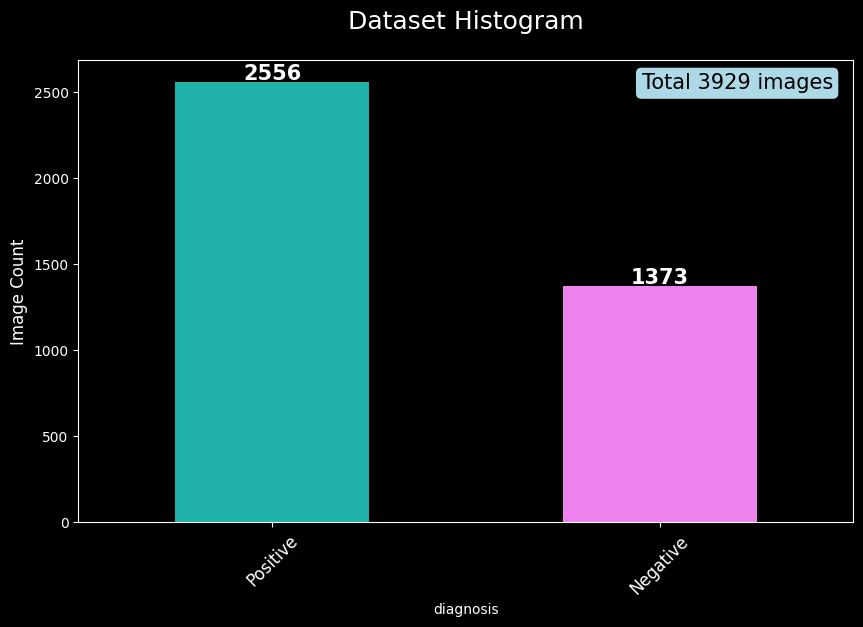

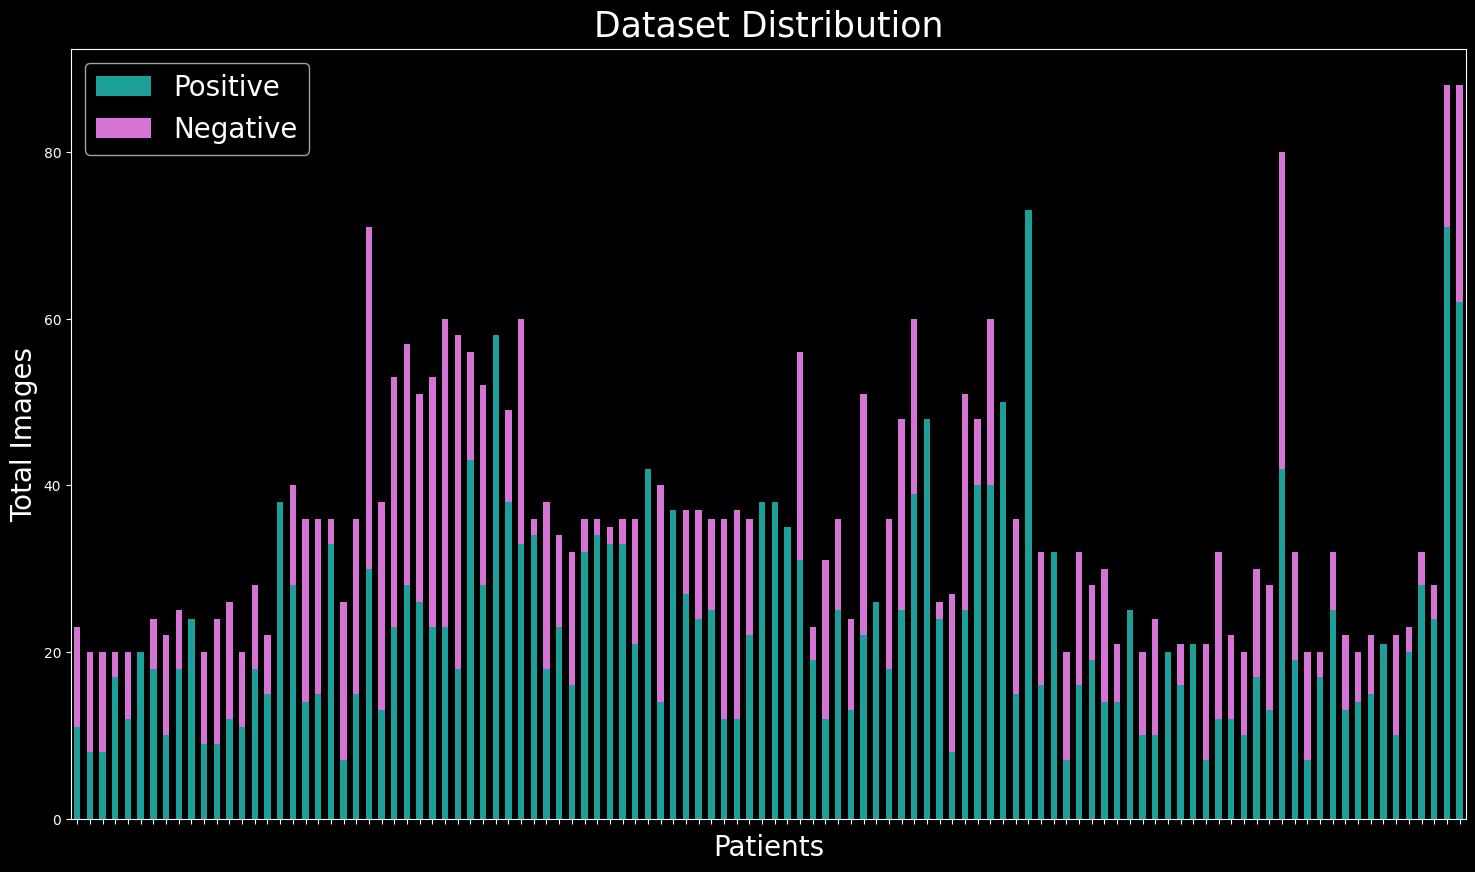

In [10]:
plot_histogram(df)
plot_distribution(df)
# plot_masks(df)

In [11]:
# sample_yes_arr, sample_no_arr = prepare_sample_images(df, row_count=3, sample_pos_df, sample_neg_df)
# # Plot
# fig = plt.figure(figsize=(10, 10))
# grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1)

# grid[0].imshow(sample_yes_arr)
# grid[0].set_title("Positive")
# grid[0].axis("off")

# grid[1].imshow(sample_no_arr)
# grid[1].set_title("Negative")
# grid[1].axis("off")

# grid[2].imshow(sample_yes_arr[:, :, 0], cmap="hot")
# grid[2].set_title("Positive")
# grid[2].axis("off")

# grid[3].imshow(sample_no_arr[:, :, 0], cmap="hot")
# grid[3].set_title("Negative")
# grid[3].axis("off")

# plt.figtext(0.36, 0.90, "Original", va="center", ha="center", size=15)
# plt.figtext(0.66, 0.90, "With hot colormap", va="center", ha="center", size=15)
# plt.show()


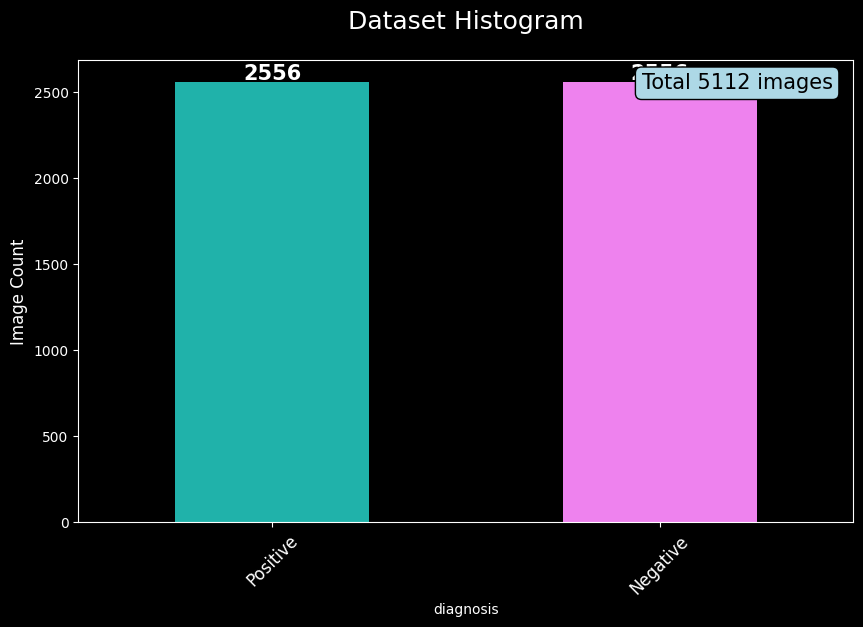

In [12]:
df = upsample_dataset(df)
plot_histogram(df)

In [13]:
train_df, temp_df = split(df, test_size=0.2)
test_df, val_df = split(temp_df, test_size=0.5)

print_data_shapes(train_df, val_df, test_df)

Dataset    Shape          
-------------------------
Train      (4089, 4)
Validation (512, 4)
Test       (511, 4)


In [14]:
from torchvision.transforms.functional import resize
class AugmentPair:
    def __init__(self, rotation_range=15, scale_range=0.2, brightness_range=(0.9, 1.1)):
        self.rotation_range = rotation_range
        self.scale_range = scale_range
        self.brightness_range = brightness_range

    def rotate(self, input, angle):
        return rotate(input, angle)

    def scale(self, data, factor):
        width, height = data.size
        data = resize(data, (int(height * factor), int(width * factor)))
        return center_crop(data, (height, width))
    
    def adjust_brightness(self, input, factor):
        return adjust_brightness(input, factor)        
        
    def __call__(self, pair):
        image, mask = pair

        angle = np.random.uniform(-self.rotation_range, self.rotation_range)
        image = self.rotate(image, angle)
        mask = self.rotate(mask, angle)

        factor = np.random.uniform(1 - self.scale_range, 1 + self.scale_range)
        image = self.scale(image, factor)
        mask = self.scale(mask, factor)

        image = self.adjust_brightness(image, factor=np.random.uniform(*self.brightness_range))

        return image, mask

class MRIDataset(Dataset):
    def __init__(self, df, transformer=None):
        self.df = df
        self.transformer = transformer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image and mask with OpenCV
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)  # 0 for grayscale

        # Convert to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        if self.transformer:
            image, mask = self.transformer((image, mask))

        # Convert to tensors
        image = to_tensor(image)
        mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, resize(mask, MASK_SIZE)


train_dataset = MRIDataset(train_df, transformer=AugmentPair())
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = MRIDataset(val_df, transformer=None)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

test_dataset = MRIDataset(test_df, transformer=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 128, 128])


In [15]:
# combined_df = pd.concat([sample_pos_df, sample_neg_df], ignore_index=True)
# shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
# dataloader_ = DataLoader(MRIDataset(shuffled_df, transformer=AugmentPair()), 
#                          batch_size=32, num_workers=4, shuffle=True)

# images_, masks_, real_images_, real_masks_ = next(iter(dataloader_))
# plot_aug(images_)
# plot_aug(masks_)
# plot_aug(real_images_)
# plot_aug(real_masks_)

In [16]:
class VGGEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(VGGEncoder, self).__init__()
        weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        vgg = models.vgg16(weights=weights)
        features = list(vgg.features.children())
        # Extract blocks for skip connections
        self.block1 = nn.Sequential(*features[:5])   # block1_pool
        self.block2 = nn.Sequential(*features[5:10]) # block2_pool
        self.block3 = nn.Sequential(*features[10:17])# block3_pool
        self.block4 = nn.Sequential(*features[17:24])# block4_pool
        self.block5 = nn.Sequential(*features[24:31])# block5_pool

    def forward(self, x):
        skip_connections = []
        
        x = self.block1(x)
        skip_connections.append(x)
        
        x = self.block2(x)
        skip_connections.append(x)
        
        x = self.block3(x)
        skip_connections.append(x)
        
        x = self.block4(x)
        skip_connections.append(x)
        
        x = self.block5(x)

        return x, skip_connections[::-1]  # Reverse for decoding
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x)  # Upsample
        x = torch.cat([x, skip], dim=1)  # Concatenate with skip connection
        x = self.relu(self.conv1(x))  # First convolution
        x = self.relu(self.conv2(x))  # Second convolution
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(512, 512, 256)  # Block 5 to Block 4
        self.decoder3 = DecoderBlock(256, 256, 128)  # Block 4 to Block 3
        self.decoder2 = DecoderBlock(128, 128, 64)   # Block 3 to Block 2
        self.decoder1 = DecoderBlock(64, 64, 32)     # Block 2 to Block 1

        # Final output layer
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x, skips):
        x = self.decoder4(x, skips[0])  # Skip from Block 4
        x = self.decoder3(x, skips[1])  # Skip from Block 3
        x = self.decoder2(x, skips[2])  # Skip from Block 2
        x = self.decoder1(x, skips[3])  # Skip from Block 1
        x = self.final_conv(x)          # Output layer
        return x

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.encoder = VGGEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        x, skips = self.encoder(x)  # Encoder forward pass
        x = self.decoder(x, skips)  # Decoder forward pass
        return x

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for images, masks in tqdm(dataloader, desc="Training", leave=False):    
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks) + criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()

    return (total_loss / len(dataloader)), (total_dice / len(dataloader)), (total_iou / len(dataloader))

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks) + criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)


In [18]:
def test_model(model, dataloader, device):
    model.eval()
    total_dice, total_iou = 0, 0
    samples = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

            # Store sample predictions for visualization
            samples.append((images.cpu(), masks.cpu(), outputs.cpu()))

    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_dice, avg_iou, samples

In [19]:
model = UNet()
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]  


UNet(
  (encoder): VGGEncoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [20]:
best_val_loss = np.inf  
early_stop_counter = 0

train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []

for epoch in range(EPOCHS):
    train_loss, train_dice, train_iou = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_dice, val_iou = validate_one_epoch(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete.")

Epoch 1/150
Train Loss: 1.0892, Train Dice: 0.0002, Train IoU: 0.0001
Val Loss: 1.0270, Val Dice: 0.0039, Val IoU: 0.0020


Epoch 2/150
Train Loss: 0.5005, Train Dice: 0.5260, Train IoU: 0.3809
Val Loss: 0.3696, Val Dice: 0.6509, Val IoU: 0.4885


Epoch 3/150
Train Loss: 0.2883, Train Dice: 0.7289, Train IoU: 0.5801
Val Loss: 0.1976, Val Dice: 0.8151, Val IoU: 0.6887


Epoch 4/150
Train Loss: 0.1994, Train Dice: 0.8129, Train IoU: 0.6877
Val Loss: 0.1729, Val Dice: 0.8379, Val IoU: 0.7215


Epoch 5/150
Train Loss: 0.1653, Train Dice: 0.8452, Train IoU: 0.7337
Val Loss: 0.1913, Val Dice: 0.8188, Val IoU: 0.6939


Epoch 6/150
Train Loss: 0.1486, Train Dice: 0.8606, Train IoU: 0.7568
Val Loss: 0.1273, Val Dice: 0.8806, Val IoU: 0.7870


Epoch 7/150
Train Loss: 0.1442, Train Dice: 0.8649, Train IoU: 0.7634
Val Loss: 0.1362, Val Dice: 0.8717, Val IoU: 0.7731


Epoch 8/150
Train Loss: 0.1323, Train Dice: 0.8758, Train IoU: 0.7798
Val Loss: 0.1169, Val Dice: 0.8903, Val IoU: 0.8025


Epoch 9/150
Train Loss: 0.1337, Train Dice: 0.8747, Train IoU: 0.7782
Val Loss: 0.1330, Val Dice: 0.8759, Val IoU: 0.7800


Epoch 10/150
Train Loss: 0.1274, Train Dice: 0.8805, Train IoU: 0.7877
Val Loss: 0.1111, Val Dice: 0.8961, Val IoU: 0.8121


Epoch 11/150
Train Loss: 0.1148, Train Dice: 0.8922, Train IoU: 0.8060
Val Loss: 0.1082, Val Dice: 0.8981, Val IoU: 0.8153


Epoch 12/150
Train Loss: 0.1132, Train Dice: 0.8936, Train IoU: 0.8084
Val Loss: 0.1118, Val Dice: 0.8944, Val IoU: 0.8092


Epoch 13/150
Train Loss: 0.1100, Train Dice: 0.8966, Train IoU: 0.8131
Val Loss: 0.1135, Val Dice: 0.8928, Val IoU: 0.8067


Epoch 14/150
Train Loss: 0.1057, Train Dice: 0.9006, Train IoU: 0.8198
Val Loss: 0.1095, Val Dice: 0.8969, Val IoU: 0.8133


Epoch 15/150
Train Loss: 0.1066, Train Dice: 0.8999, Train IoU: 0.8187
Val Loss: 0.0977, Val Dice: 0.9084, Val IoU: 0.8323


Epoch 16/150
Train Loss: 0.1321, Train Dice: 0.8760, Train IoU: 0.7813
Val Loss: 0.1104, Val Dice: 0.8961, Val IoU: 0.8121


Epoch 17/150
Train Loss: 0.1037, Train Dice: 0.9025, Train IoU: 0.8228
Val Loss: 0.0954, Val Dice: 0.9102, Val IoU: 0.8353


Epoch 18/150
Train Loss: 0.0992, Train Dice: 0.9066, Train IoU: 0.8296
Val Loss: 0.0924, Val Dice: 0.9132, Val IoU: 0.8405


Epoch 19/150
Train Loss: 0.0962, Train Dice: 0.9095, Train IoU: 0.8345
Val Loss: 0.1126, Val Dice: 0.8934, Val IoU: 0.8076


Epoch 20/150
Train Loss: 0.0949, Train Dice: 0.9107, Train IoU: 0.8364
Val Loss: 0.0908, Val Dice: 0.9150, Val IoU: 0.8436


Epoch 21/150
Train Loss: 0.0918, Train Dice: 0.9136, Train IoU: 0.8413
Val Loss: 0.0990, Val Dice: 0.9065, Val IoU: 0.8293


Epoch 22/150
Train Loss: 0.0907, Train Dice: 0.9147, Train IoU: 0.8430
Val Loss: 0.0891, Val Dice: 0.9163, Val IoU: 0.8457


Epoch 23/150
Train Loss: 0.0886, Train Dice: 0.9167, Train IoU: 0.8465
Val Loss: 0.0870, Val Dice: 0.9182, Val IoU: 0.8489


Epoch 24/150
Train Loss: 0.0949, Train Dice: 0.9107, Train IoU: 0.8365
Val Loss: 0.0978, Val Dice: 0.9076, Val IoU: 0.8310


Epoch 25/150
Train Loss: 0.1042, Train Dice: 0.9020, Train IoU: 0.8224
Val Loss: 0.1106, Val Dice: 0.8964, Val IoU: 0.8129


Epoch 26/150
Train Loss: 0.1037, Train Dice: 0.9025, Train IoU: 0.8229
Val Loss: 0.0949, Val Dice: 0.9108, Val IoU: 0.8365


Epoch 27/150
Train Loss: 0.0906, Train Dice: 0.9147, Train IoU: 0.8433
Val Loss: 0.0865, Val Dice: 0.9188, Val IoU: 0.8500


Epoch 28/150
Train Loss: 0.0879, Train Dice: 0.9173, Train IoU: 0.8475
Val Loss: 0.0936, Val Dice: 0.9116, Val IoU: 0.8377


Epoch 29/150
Train Loss: 0.0838, Train Dice: 0.9211, Train IoU: 0.8539
Val Loss: 0.0866, Val Dice: 0.9186, Val IoU: 0.8496


Epoch 30/150
Train Loss: 0.0819, Train Dice: 0.9229, Train IoU: 0.8571
Val Loss: 0.0853, Val Dice: 0.9197, Val IoU: 0.8515


Epoch 31/150
Train Loss: 0.0814, Train Dice: 0.9234, Train IoU: 0.8579
Val Loss: 0.0846, Val Dice: 0.9203, Val IoU: 0.8526


Epoch 32/150
Train Loss: 0.0876, Train Dice: 0.9176, Train IoU: 0.8481
Val Loss: 0.0887, Val Dice: 0.9166, Val IoU: 0.8462


Epoch 33/150
Train Loss: 0.0828, Train Dice: 0.9221, Train IoU: 0.8556
Val Loss: 0.0884, Val Dice: 0.9166, Val IoU: 0.8461


Epoch 34/150
Train Loss: 0.0821, Train Dice: 0.9227, Train IoU: 0.8568
Val Loss: 0.0854, Val Dice: 0.9195, Val IoU: 0.8511


Epoch 35/150
Train Loss: 0.0834, Train Dice: 0.9215, Train IoU: 0.8546
Val Loss: 0.0824, Val Dice: 0.9227, Val IoU: 0.8566


Epoch 36/150
Train Loss: 0.0793, Train Dice: 0.9253, Train IoU: 0.8612
Val Loss: 0.0820, Val Dice: 0.9229, Val IoU: 0.8569


Epoch 37/150
Train Loss: 0.0830, Train Dice: 0.9219, Train IoU: 0.8556
Val Loss: 0.0890, Val Dice: 0.9166, Val IoU: 0.8462


Epoch 38/150
Train Loss: 0.2038, Train Dice: 0.8093, Train IoU: 0.7138
Val Loss: 0.2815, Val Dice: 0.7349, Val IoU: 0.5833


Epoch 39/150
Train Loss: 0.1842, Train Dice: 0.8276, Train IoU: 0.7112
Val Loss: 0.1279, Val Dice: 0.8800, Val IoU: 0.7862


Epoch 40/150
Train Loss: 0.1104, Train Dice: 0.8964, Train IoU: 0.8129
Val Loss: 0.1031, Val Dice: 0.9029, Val IoU: 0.8232


Epoch 41/150
Train Loss: 0.1005, Train Dice: 0.9054, Train IoU: 0.8279
Val Loss: 0.0953, Val Dice: 0.9105, Val IoU: 0.8359
Early stopping triggered at epoch 41
Training complete.


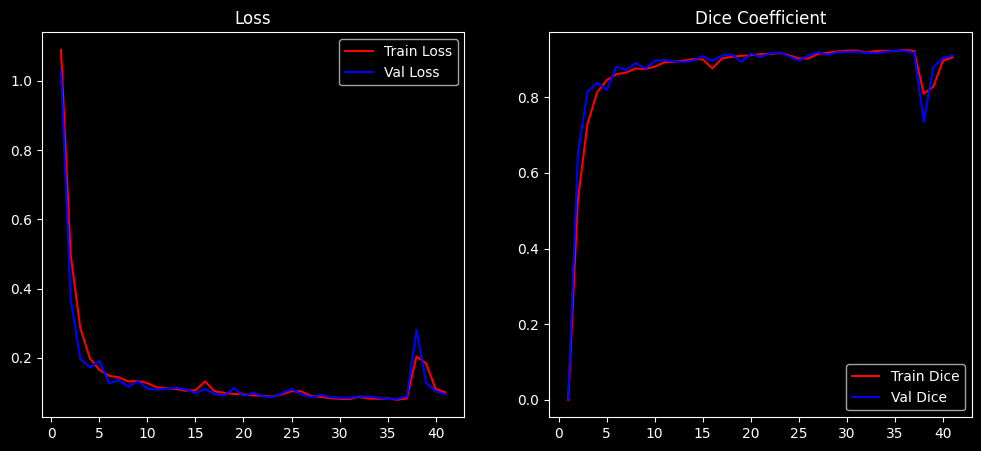

In [21]:
plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores)

In [22]:
state_dict = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device) 
test_loss, test_dice, test_iou = validate_one_epoch(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")

/tmp/ipykernel_23/4013297025.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth", map_location=device)
                             

Test Loss: 0.0830, Test Dice: 0.9220, Test IoU: 0.8555


In [25]:
avg_dice, avg_iou, samples = test_model(model, test_dataloader, device)
print(f"Test Avg Dice Score: {avg_dice:.4f}, Test Avg IoU Score: {avg_iou:.4f}")

Test Avg Dice Score: 0.9220, Test Avg IoU Score: 0.8555


In [58]:
# def plot_samples(samples, num_samples=5):
#     num_samples = min(num_samples, len(samples))
    
#     for i in range(num_samples):
#         images, masks, outputs = samples[i]
#         # Assuming batch size > 1; take the first sample of the batch
#         image = images[0].numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
#         mask = masks[0].numpy().squeeze()  # (1, H, W) -> (H, W)
#         output = outputs[0].numpy().squeeze()  # (1, H, W) -> (H, W)
        
#         # Binarize output for visualization
#         pred_mask = (output > 0.5).astype(np.uint8)
        
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         axes[0].imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
#         axes[0].set_title('Input Image')
#         axes[0].axis('off')
        
#         axes[1].imshow(mask, cmap='gray')
#         axes[1].set_title('Ground Truth Mask')
#         axes[1].axis('off')
        
#         axes[2].imshow(pred_mask, cmap='gray')
#         axes[2].set_title('Predicted Mask')
#         axes[2].axis('off')
        
#         plt.show()

def plot_samples(samples, num_samples=5):
    num_samples = min(num_samples, len(samples))
    
    for i in range(num_samples):
        images, masks, outputs = samples[i]
        
        # Take the first sample from the batch
        image = images[0].numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        mask = masks[0].numpy().squeeze()  # (1, H, W) -> (H, W)
        output = outputs[0].numpy().squeeze()  # (1, H, W) -> (H, W)
        
        # Binarize output for visualization
        pred_mask = (output > 0.5).astype(np.uint8)
        
        if image.max() > 1:
            image = image / 255.0

        fig, axes = plt.subplots(1, 4, figsize=(18, 6))
        
        # Input Image
        axes[0].imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
        axes[0].set_title('Input Image', fontsize=14)
        axes[0].axis('off')
        
        # Ground Truth Mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask', fontsize=14)
        axes[1].axis('off')
        
        # Predicted Mask
        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title('Predicted Mask', fontsize=14)
        axes[2].axis('off')

        # Detection Heatmap
        axes[3].imshow(mask, cmap='Reds', alpha=0.5)
        axes[3].imshow(pred_mask, cmap='Greens', alpha=0.5)
        axes[3].set_title('Detection Heatmap', fontsize=14)
        axes[3].axis('off')
        
        # Improve spacing between plots
        fig.tight_layout()
        plt.show()


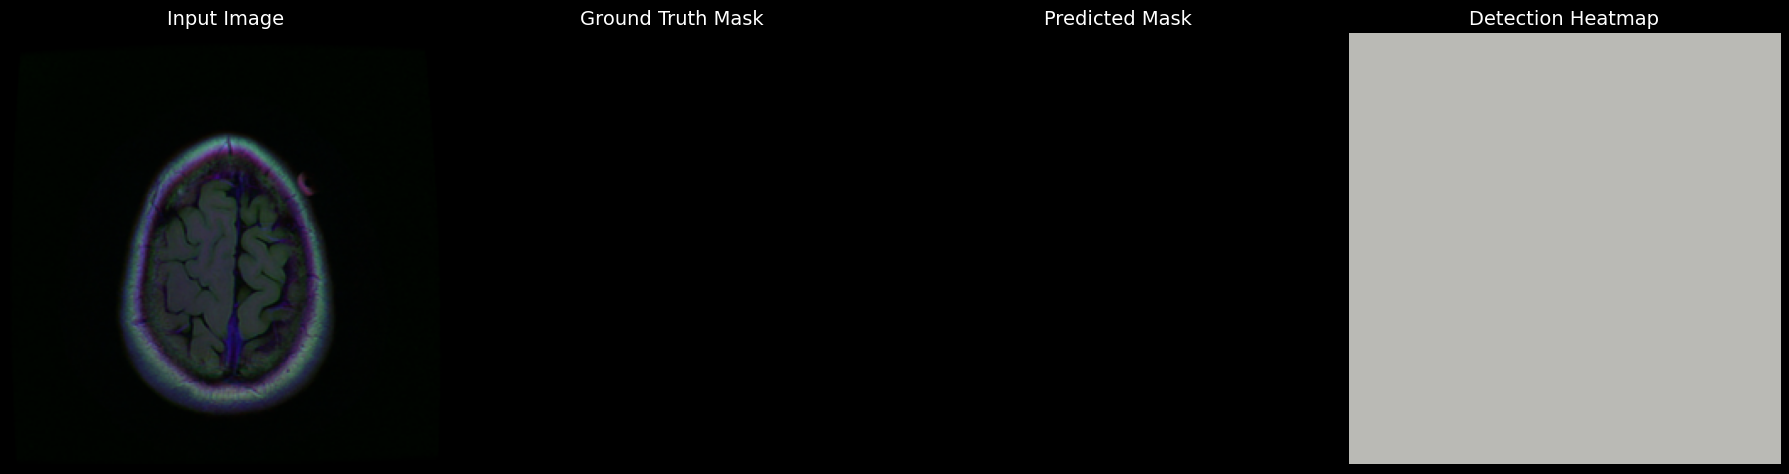

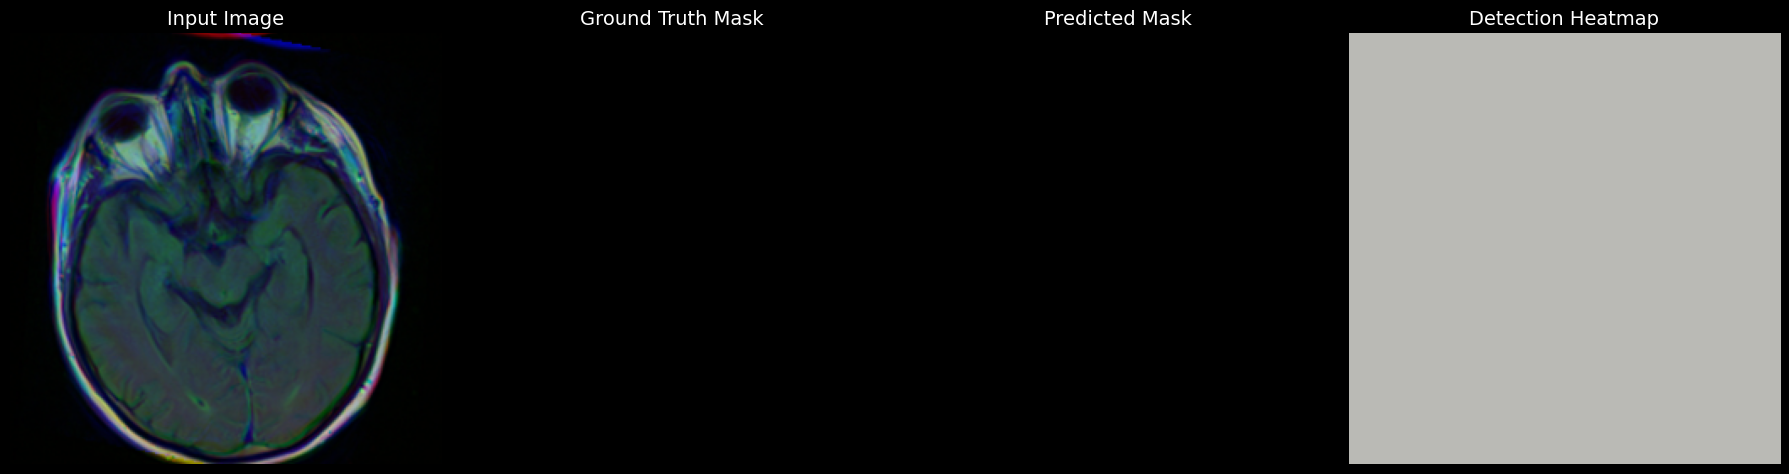

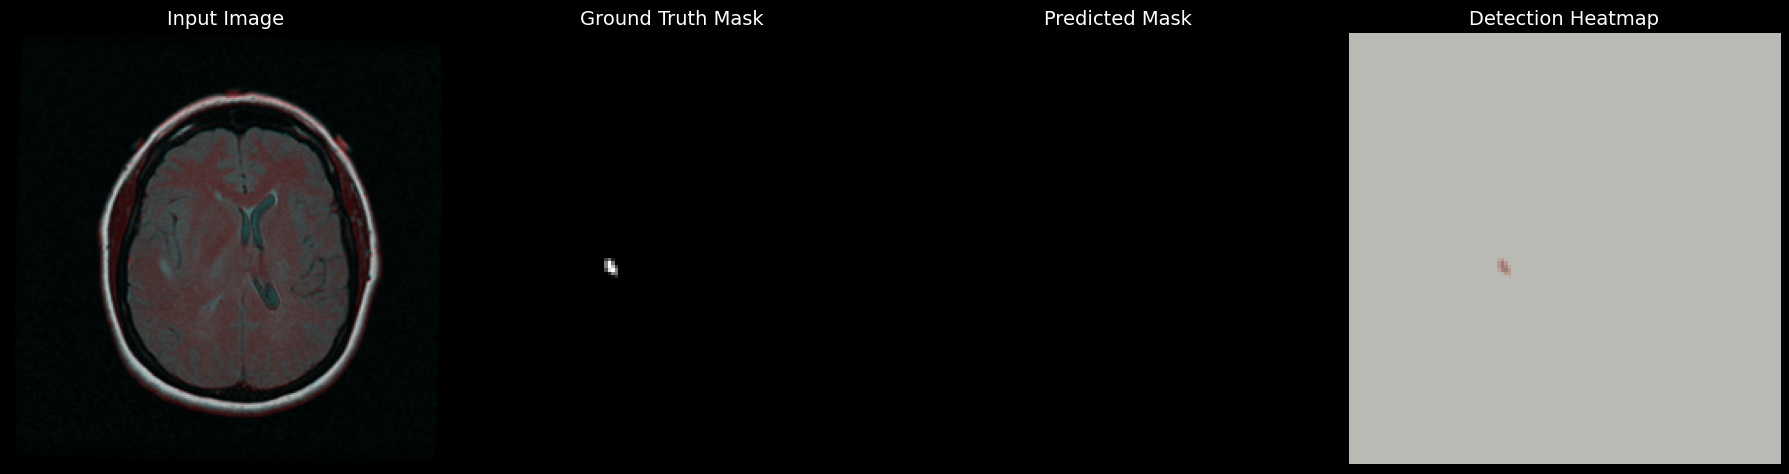

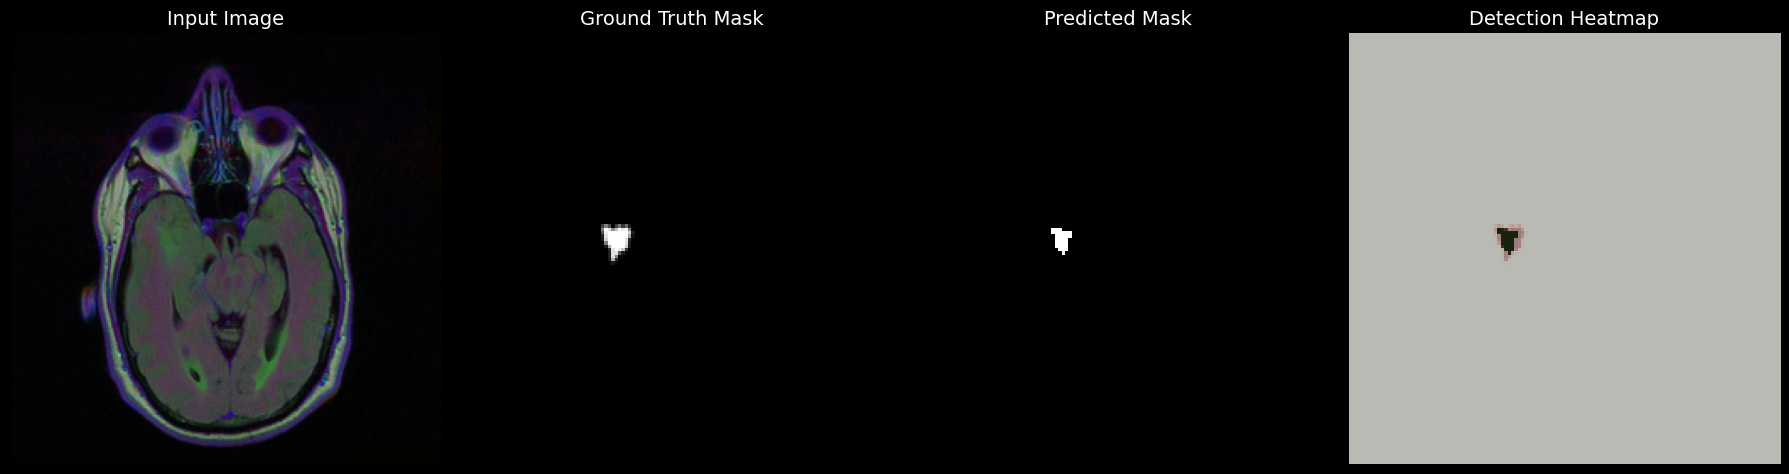

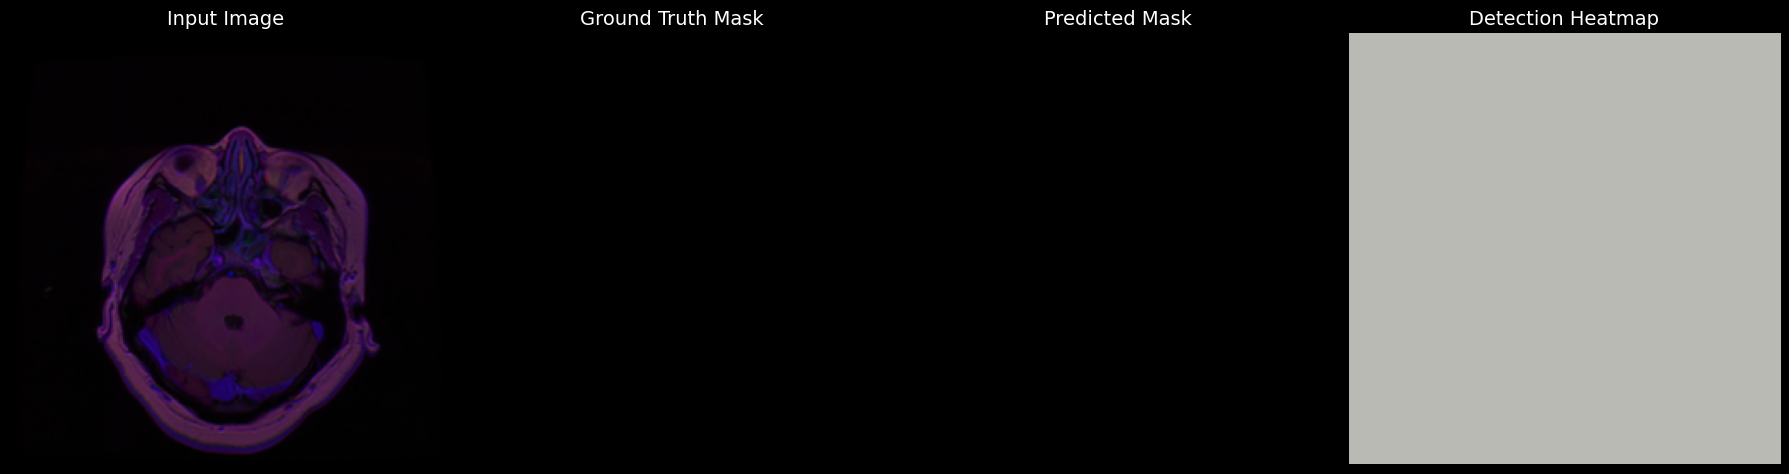

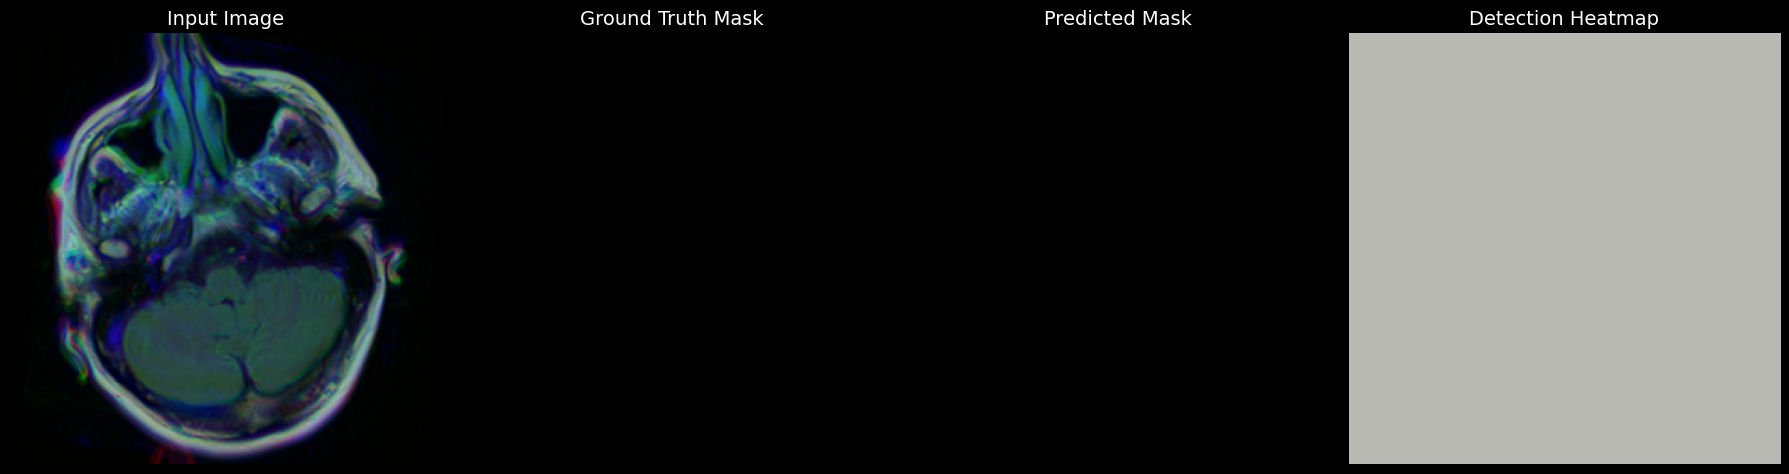

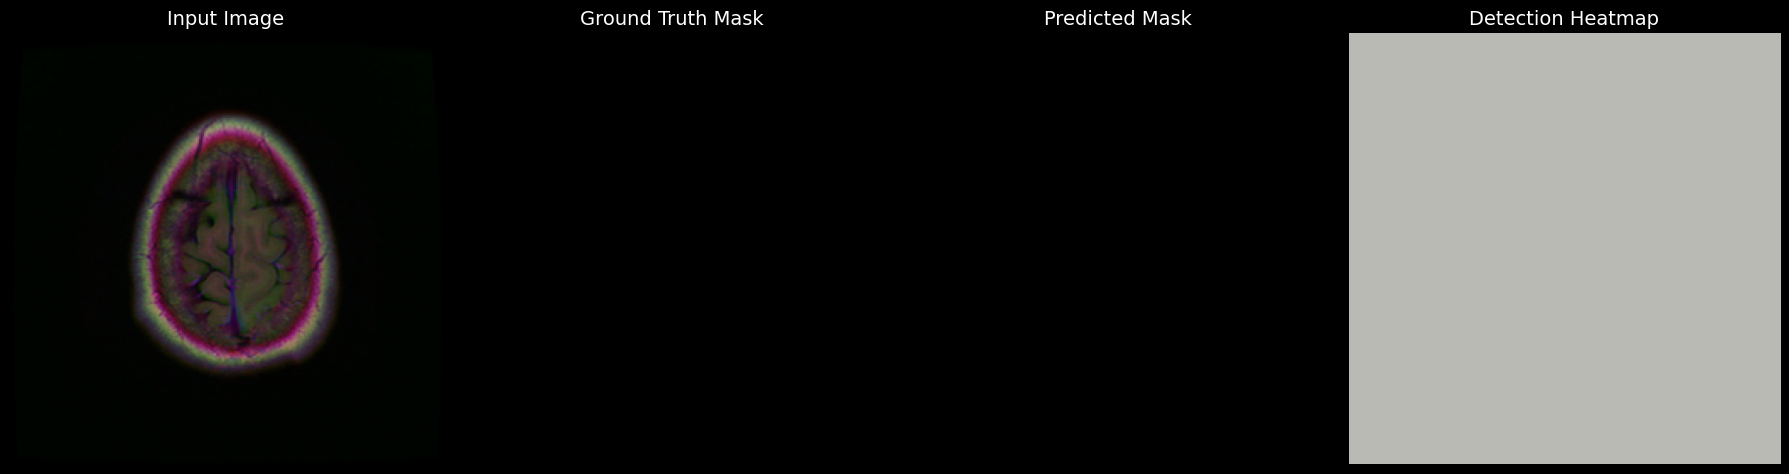

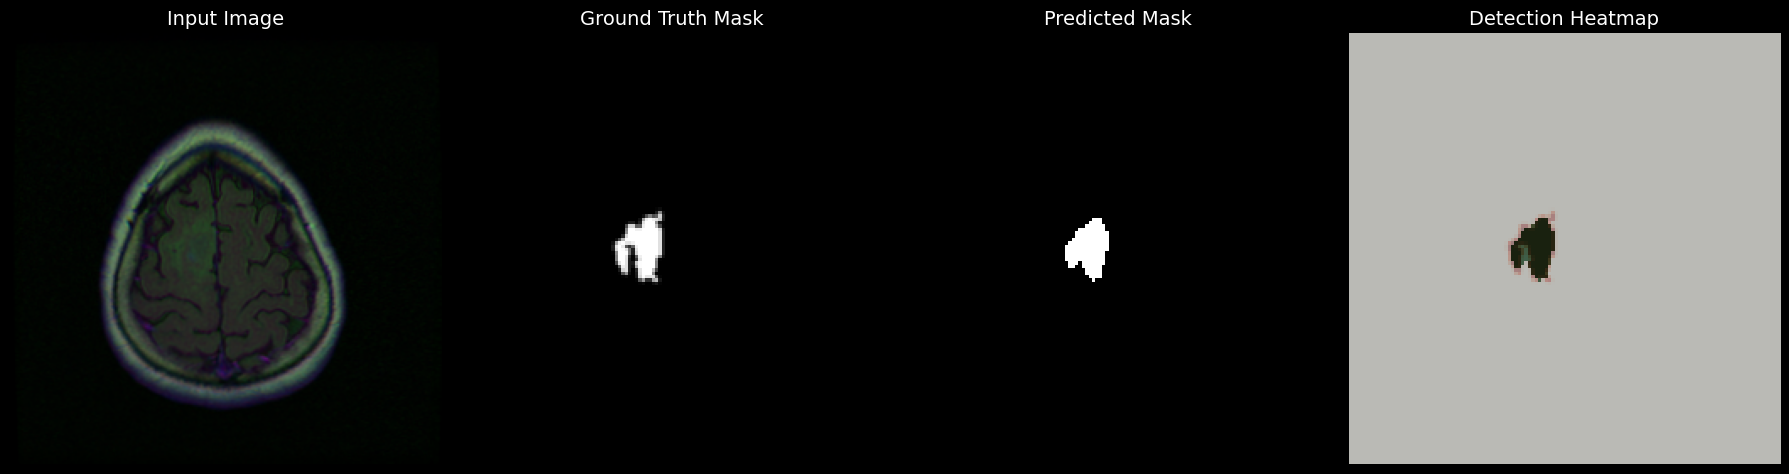

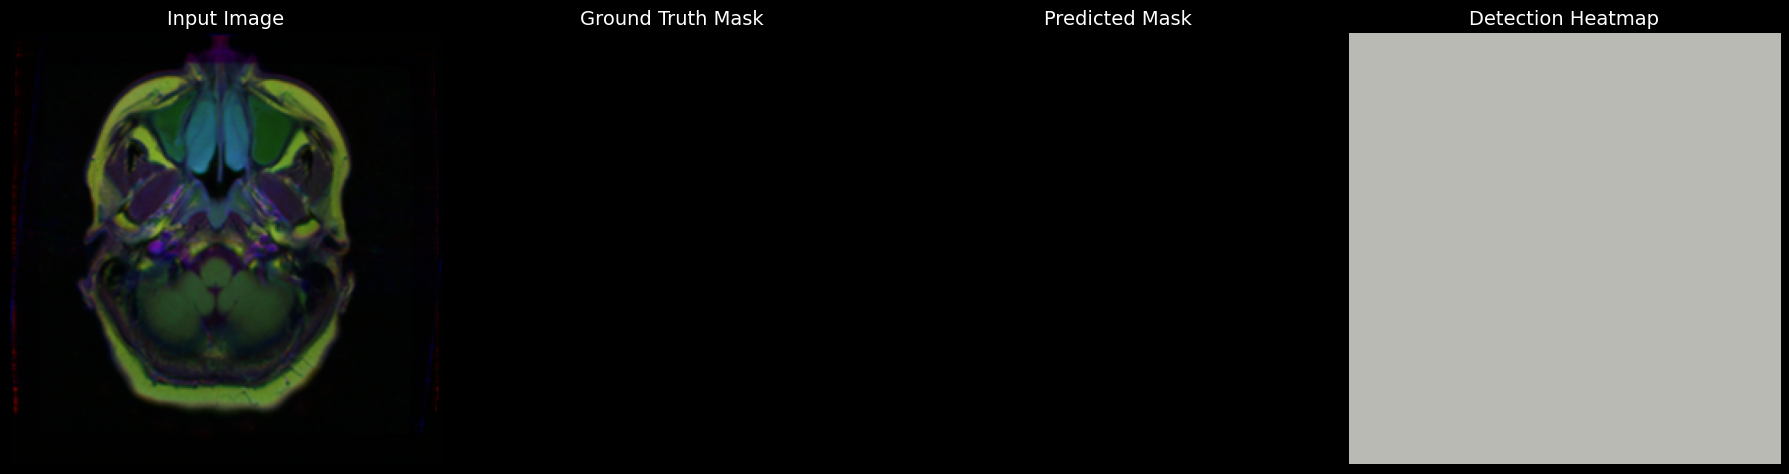

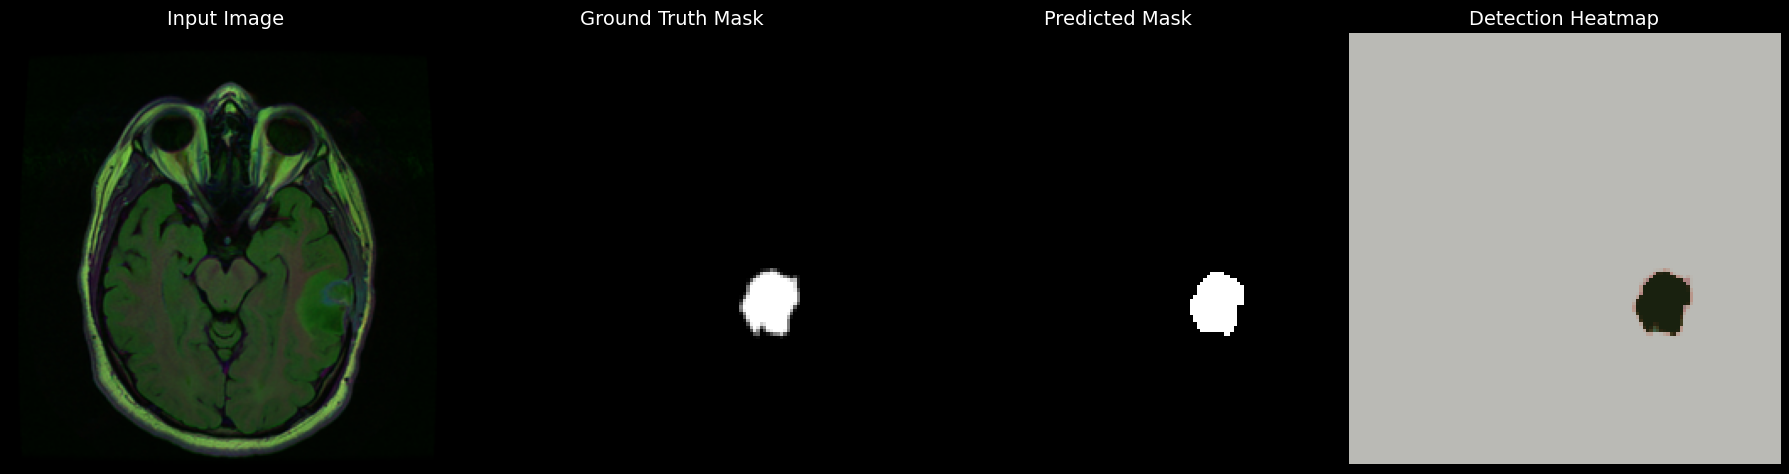

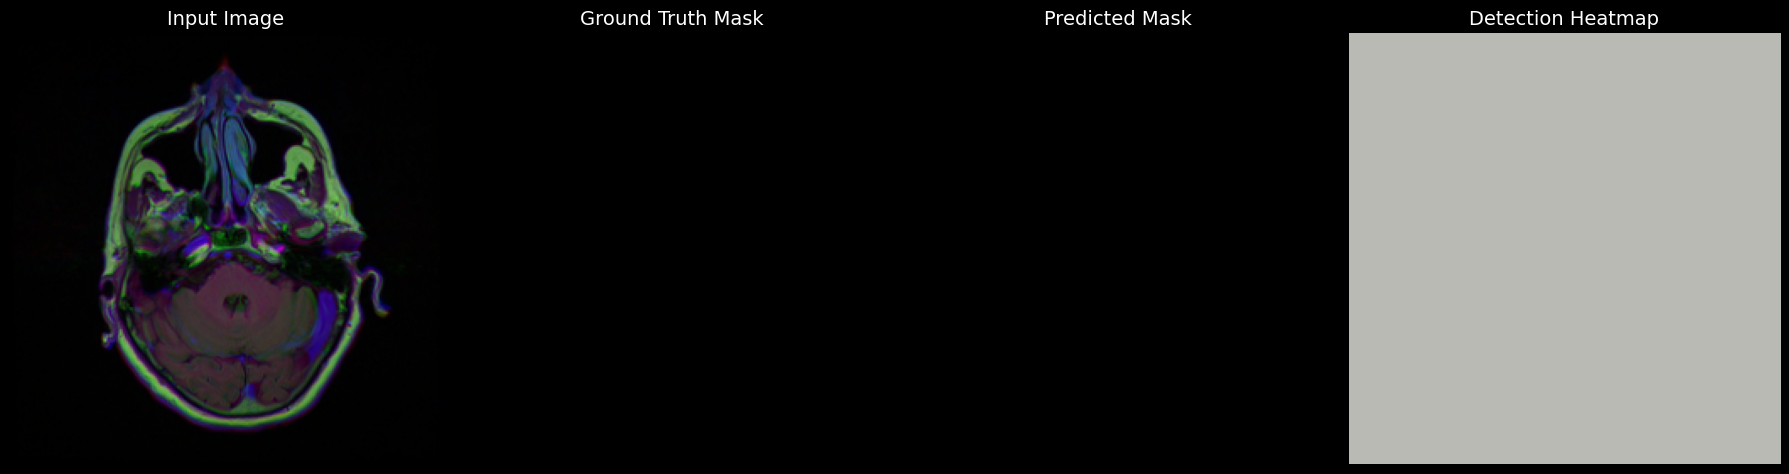

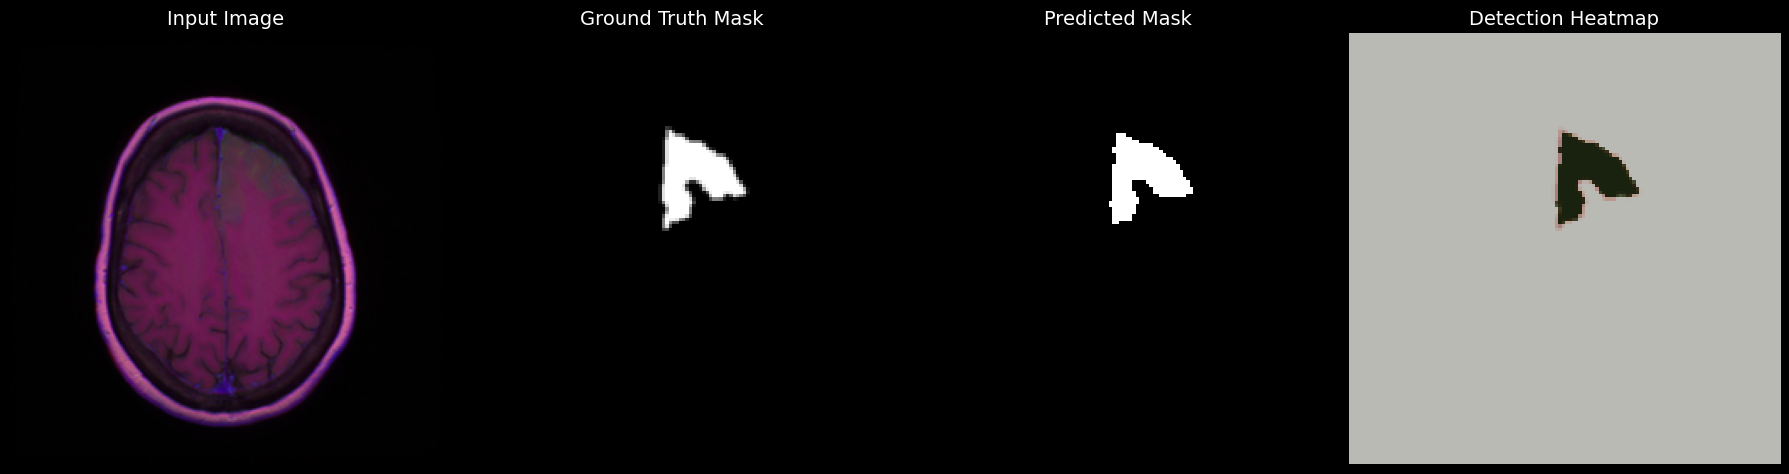

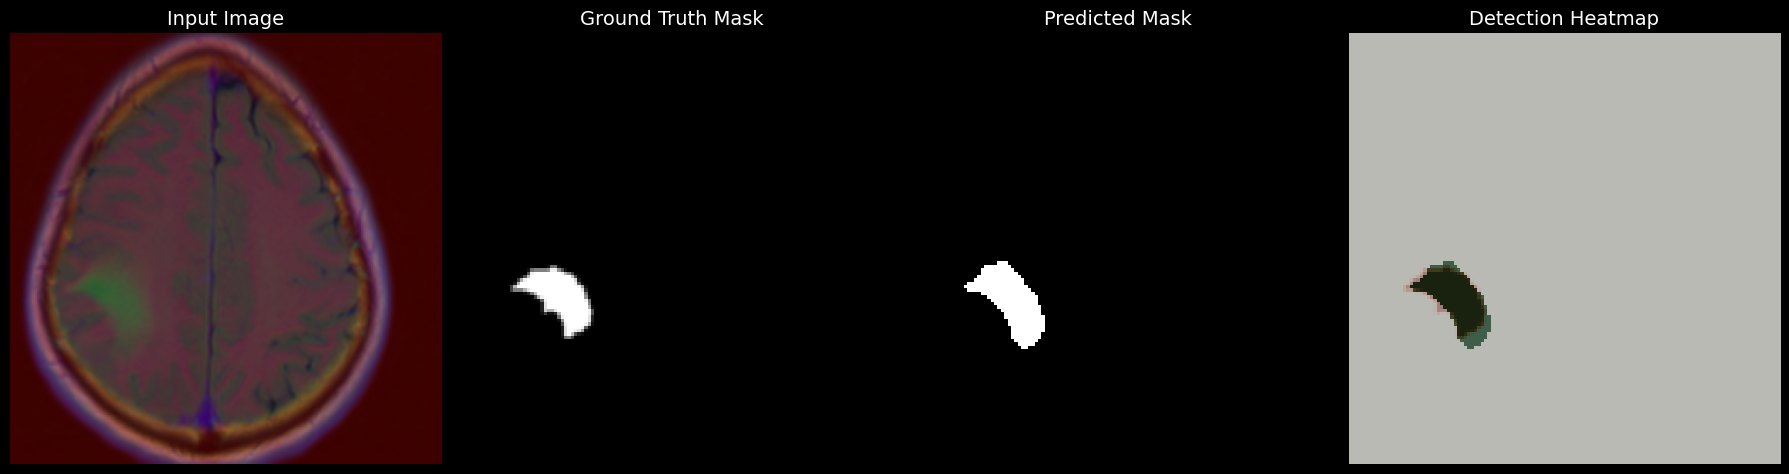

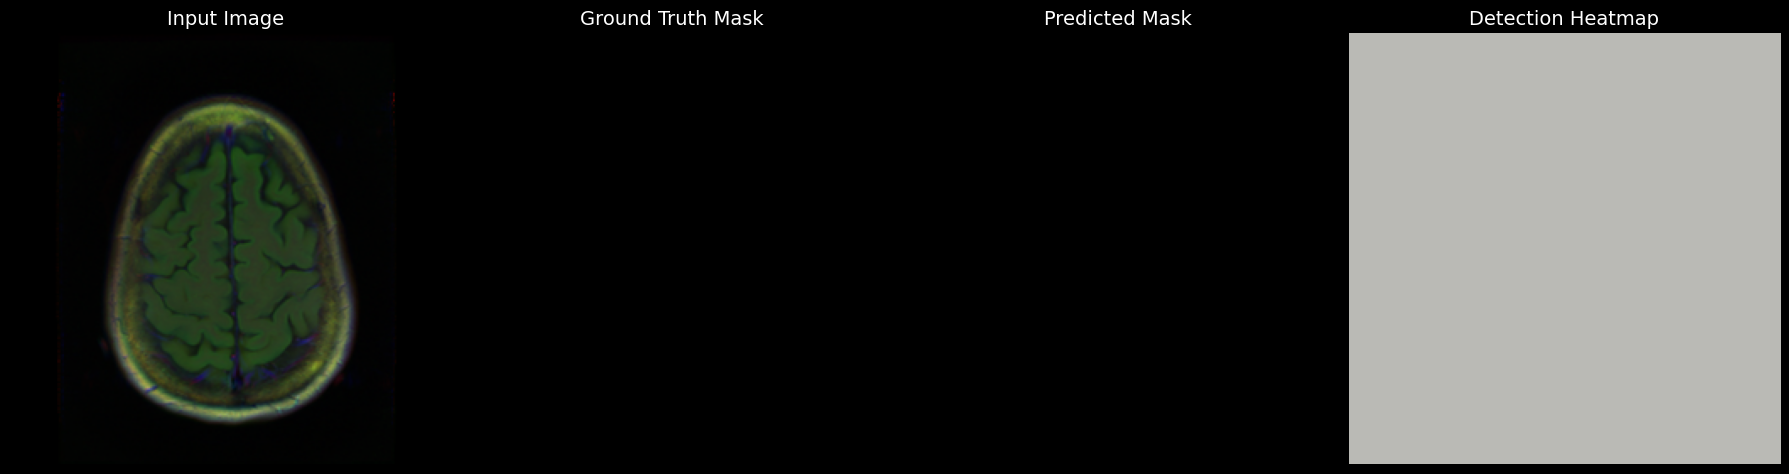

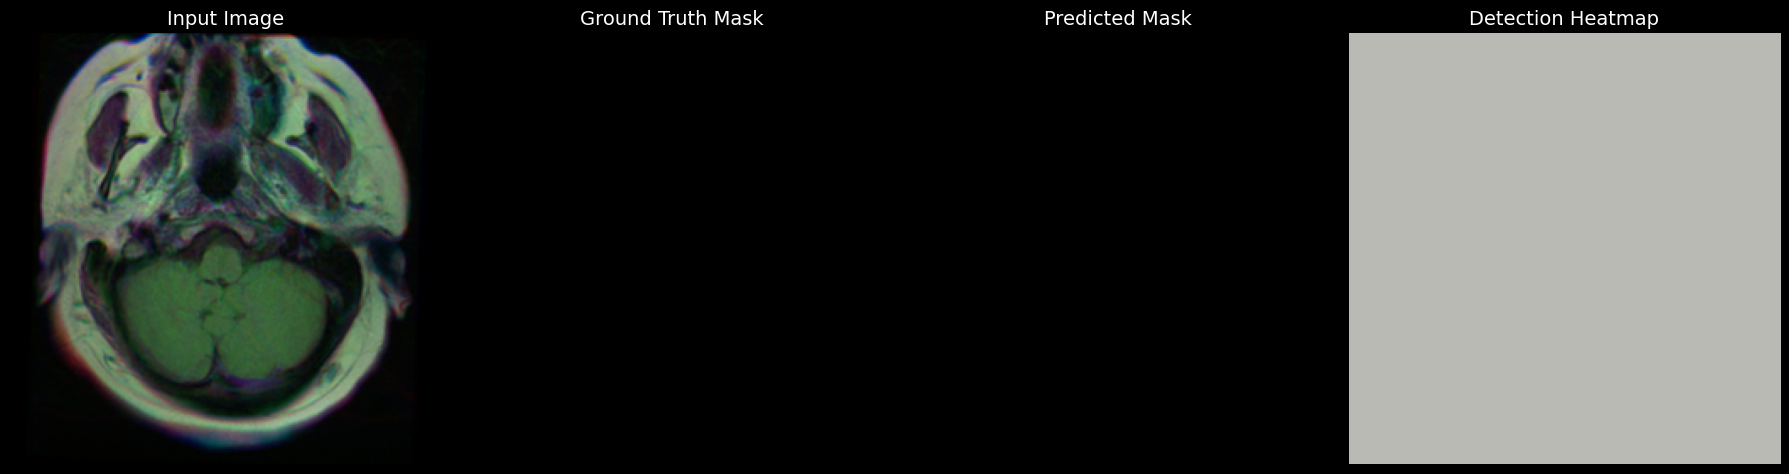

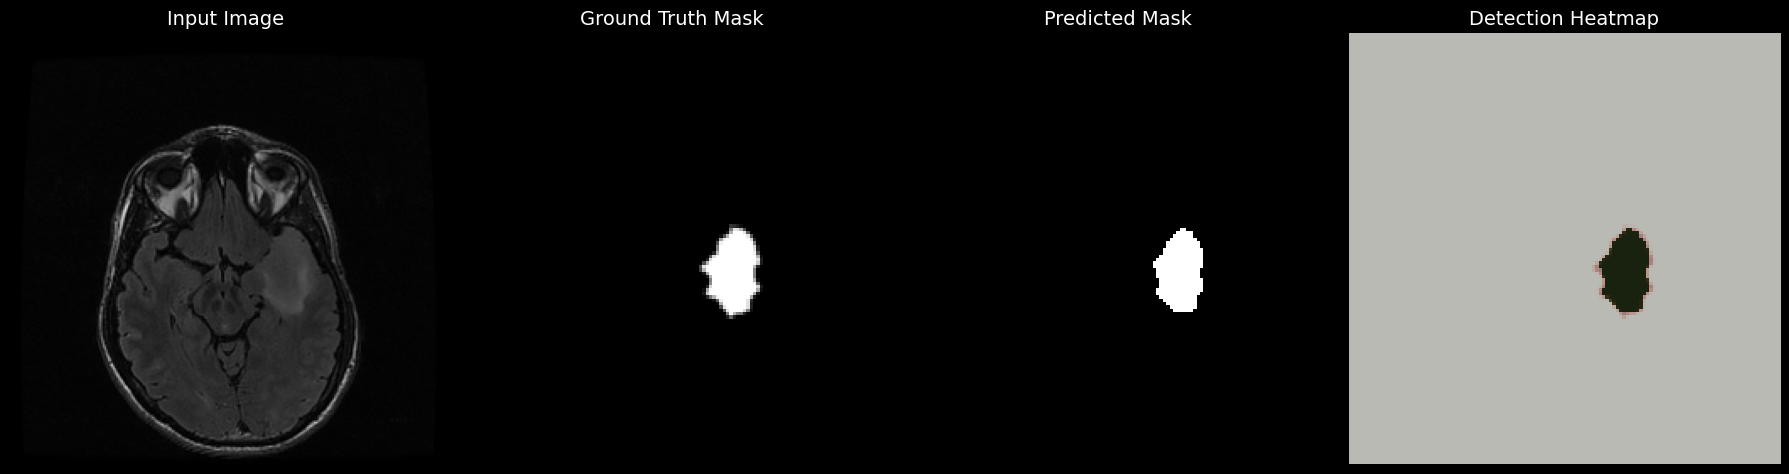

In [59]:
plot_samples(samples, num_samples=25)